In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import logging

tf.get_logger().setLevel(logging.ERROR)

In [2]:
img_height, img_width = IMG_SIZE = (200, 200)
batch_size = 32

data_dir = "Plastic Dataset"

In [3]:
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 199 files belonging to 2 classes.
Using 140 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 199 files belonging to 2 classes.
Using 59 files for validation.


In [5]:
# List the classes
class_names = train_ds.class_names
print(class_names)

['Cold', 'Hot']


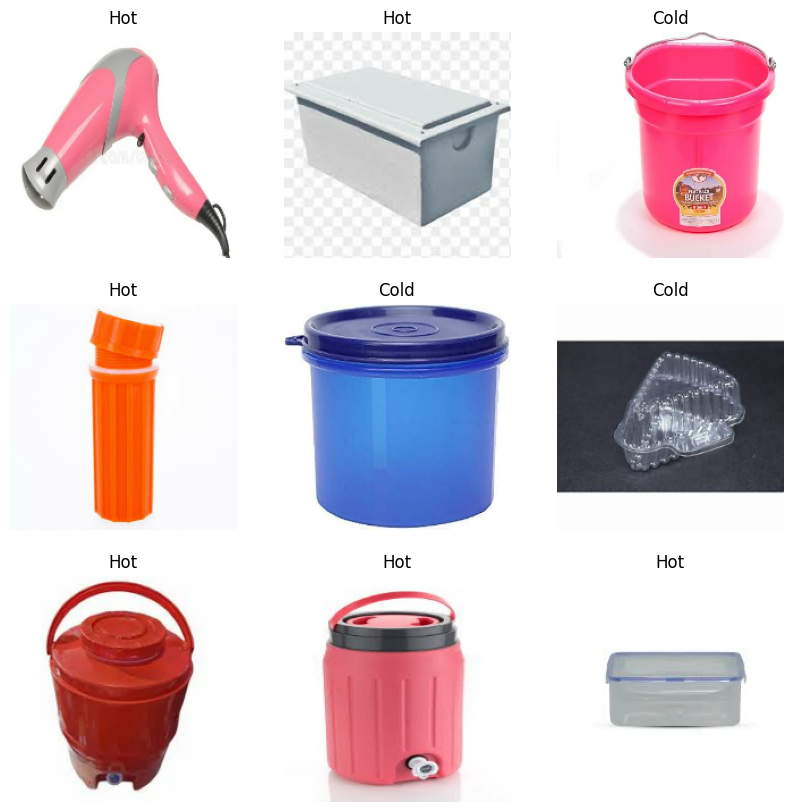

In [6]:
# Get a look at what we are training on
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [7]:
# Prefetch images to memory, to make training faster
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)

mobilenet_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

vgg16_base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

xception_base_model = tf.keras.applications.Xception(input_shape=IMG_SIZE + (3,),
                               include_top=False,
                               weights='imagenet')

efficientnet_base_model = tf.keras.applications.EfficientNetB5(input_shape=IMG_SIZE + (3,),
                                include_top=False,
                                weights='imagenet')

In [19]:
# Keep the pre-trained weights, set this to true to retrain the whole model.
mobilenet_base_model.trainable = False
vgg16_base_model.trainable = True
xception_base_model.trainable = True
efficientnet_base_model.trainable = True

In [20]:
# Define global average pooling layers for both models
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Shared model building block after feature extraction
def create_model(base_model):
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    # x = data_augmentation(inputs)
    # if base_model == mobilenet_base_model:
    #     x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # Preprocess for MobileNetV2
    x = base_model(inputs, training=True)
    # x = global_average_layer(x)
    # x = tf.keras.layers.Dropout(0.2)(x)
    predictions = tf.keras.layers.Dense(len(class_names))(x)
    return tf.keras.Model(inputs, predictions)

# Create separate models for MobileNet and VGG16
mobilenet_model = create_model(mobilenet_base_model)
vgg16_model = create_model(vgg16_base_model)
xception_model = create_model(xception_base_model)
efficientnet_model = create_model(efficientnet_base_model)

In [21]:
base_learning_rate = 0.0001

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

xception_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
mobilenet_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 7, 7, 2)           2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
vgg16_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 dense_5 (Dense)             (None, 6, 6, 2)           1026      
                                                                 
Total params: 14,715,714
Trainable params: 14,715,714
Non-trainable params: 0
_________________________________________________________________


In [24]:
xception_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dense_6 (Dense)             (None, 7, 7, 2)           4098      
                                                                 
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


In [25]:
efficientnet_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 dense_7 (Dense)             (None, 7, 7, 2)           4098      
                                                                 
Total params: 28,517,625
Trainable params: 28,344,882
Non-trainable params: 172,743
_________________________________________________________________


In [26]:
initial_epochs = 100

loss0, accuracy0 = mobilenet_model.evaluate(val_ds)
loss1, accuracy1 = vgg16_model.evaluate(val_ds)
loss2, accuracy2 = xception_model.evaluate(val_ds)
loss3, accuracy3 = efficientnet_model.evaluate(val_ds)

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\SANYAM\AppData\Local\Temp\ipykernel_15724\2121854856.py", line 3, in <module>
      loss0, accuracy0 = mobilenet_model.evaluate(val_ds)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1667, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\SANYAM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [1568,2] and labels shape [32]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_test_function_36165]

In [27]:
print("initial loss mobilenet: {:.2f}".format(loss0))
print("initial accuracy mobilenet: {:.2f}".format(accuracy0))

print("\ninitial loss vgg16: {:.2f}".format(loss1))
print("initial accuracy vgg16: {:.2f}".format(accuracy1))

print("\ninitial loss xception: {:.2f}".format(loss2))
print("initial accuracy xception: {:.2f}".format(accuracy2))

print("\ninitial loss efficientnet: {:.2f}".format(loss2))
print("initial accuracy efficientnet: {:.2f}".format(accuracy3))

NameError: name 'loss0' is not defined

In [ ]:
mobilenet_history = mobilenet_model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/100
5/5 [==============================] - 32s 2s/step - loss: 0.8355 - accuracy: 0.5929 - val_loss: 0.6943 - val_accuracy: 0.5593
Epoch 2/100
5/5 [==============================] - 9s 2s/step - loss: 0.7850 - accuracy: 0.5643 - val_loss: 0.6447 - val_accuracy: 0.6780
Epoch 3/100
5/5 [==============================] - 9s 2s/step - loss: 0.7201 - accuracy: 0.6214 - val_loss: 0.6212 - val_accuracy: 0.6271
Epoch 4/100
5/5 [==============================] - 9s 2s/step - loss: 0.6827 - accuracy: 0.6357 - val_loss: 0.6127 - val_accuracy: 0.6610
Epoch 5/100
5/5 [==============================] - 9s 2s/step - loss: 0.5871 - accuracy: 0.6929 - val_loss: 0.6027 - val_accuracy: 0.6610
Epoch 6/100
5/5 [==============================] - 9s 2s/step - loss: 0.6335 - accuracy: 0.6286 - val_loss: 0.5962 - val_accuracy: 0.6780
Epoch 7/100
5/5 [==============================] - 9s 2s/step - loss: 0.5191 - accuracy: 0.7643 - val_loss: 0.5868 - val_accuracy: 0.6780
Epoch 8/100
5/5 [================

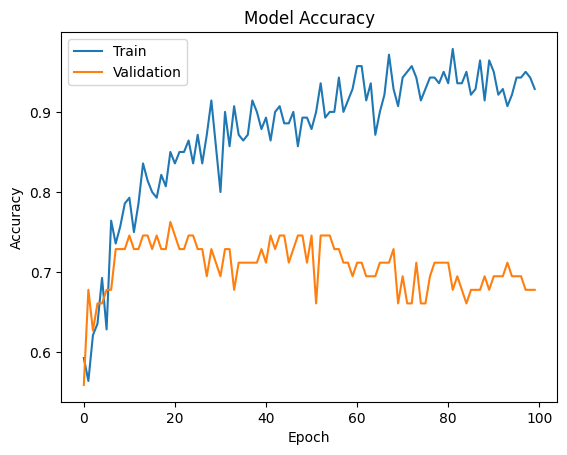

In [ ]:
# Plot training and validation accuracy
plt.plot(mobilenet_history.history['accuracy'])
plt.plot(mobilenet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

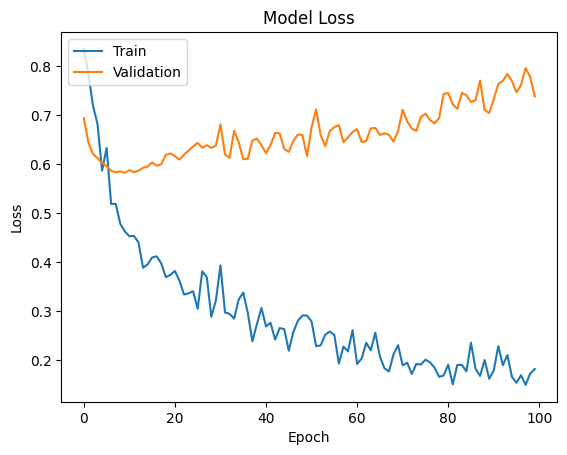

In [ ]:
# Plot training and validation loss
plt.plot(mobilenet_history.history['loss'])
plt.plot(mobilenet_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
vgg16_history = vgg16_model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/100


5/5 [==============================] - 74s 10s/step - loss: 4.4968 - accuracy: 0.4429 - val_loss: 4.2284 - val_accuracy: 0.4237
Epoch 2/100
5/5 [==============================] - 45s 9s/step - loss: 4.0698 - accuracy: 0.4929 - val_loss: 4.1055 - val_accuracy: 0.5424
Epoch 3/100
5/5 [==============================] - 43s 9s/step - loss: 3.1951 - accuracy: 0.5071 - val_loss: 3.4968 - val_accuracy: 0.5254
Epoch 4/100
5/5 [==============================] - 30s 6s/step - loss: 3.0271 - accuracy: 0.5214 - val_loss: 3.2018 - val_accuracy: 0.4746
Epoch 5/100
5/5 [==============================] - 18s 4s/step - loss: 2.7686 - accuracy: 0.5571 - val_loss: 3.0468 - val_accuracy: 0.4915
Epoch 6/100
3/5 [=================>............] - ETA: 6s - loss: 2.7431 - accuracy: 0.4896

KeyboardInterrupt: 

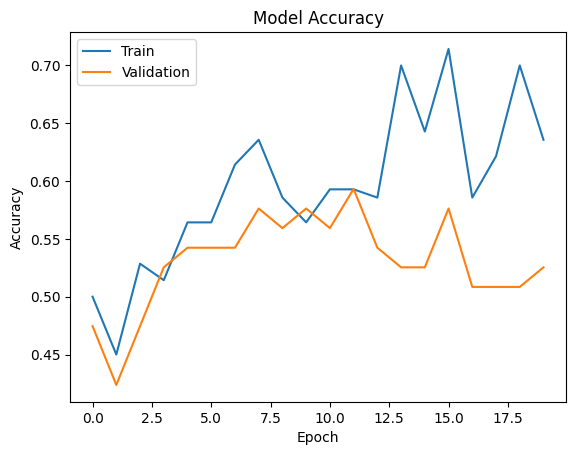

In [ ]:
# Plot training and validation accuracy
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

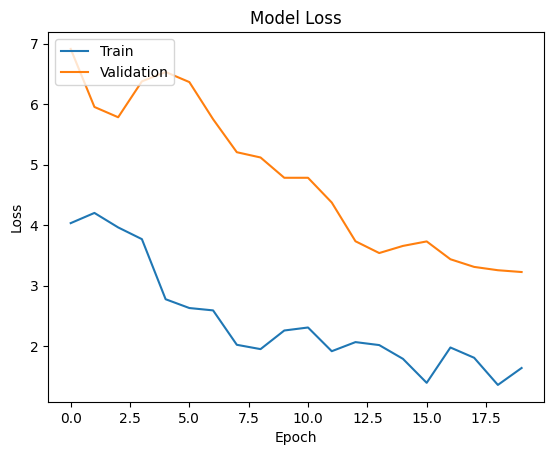

In [ ]:
# Plot training and validation loss
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
xception_history = xception_model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
5/5 [==============================] - 30s 2s/step - loss: 11.4465 - accuracy: 0.5571 - val_loss: 11.2964 - val_accuracy: 0.4068
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 12.4685 - accuracy: 0.4429 - val_loss: 8.5931 - val_accuracy: 0.4237
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 10.2950 - accuracy: 0.5357 - val_loss: 7.4228 - val_accuracy: 0.5763
Epoch 4/20
5/5 [==============================] - 11s 2s/step - loss: 9.6509 - accuracy: 0.5929 - val_loss: 6.6093 - val_accuracy: 0.4915
Epoch 5/20
5/5 [==============================] - 11s 2s/step - loss: 10.8441 - accuracy: 0.5071 - val_loss: 8.5633 - val_accuracy: 0.5254
Epoch 6/20
5/5 [==============================] - 11s 2s/step - loss: 9.4094 - accuracy: 0.5571 - val_loss: 6.1847 - val_accuracy: 0.5593
Epoch 7/20
5/5 [==============================] - 11s 2s/step - loss: 6.9433 - accuracy: 0.6000 - val_loss: 7.4824 - val_accuracy: 0.5593
Epoch 8/20
5/5 [=============

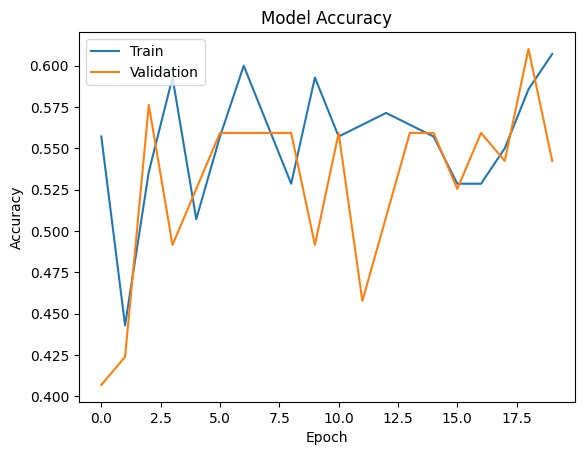

In [ ]:
# Plot training and validation accuracy
plt.plot(xception_history.history['accuracy'])
plt.plot(xception_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

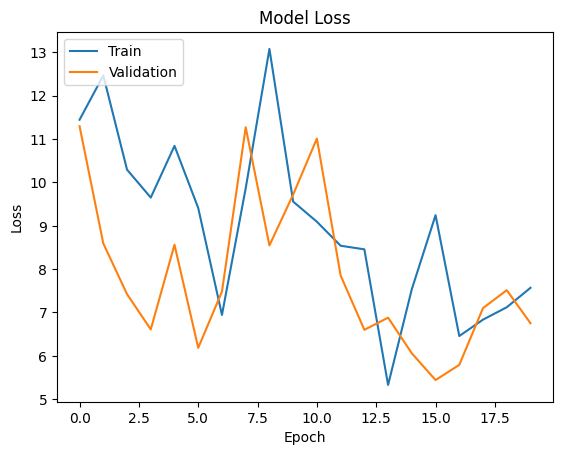

In [ ]:
# Plot training and validation loss
plt.plot(xception_history.history['loss'])
plt.plot(xception_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
efficientnet_history = efficientnet_model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
5/5 [==============================] - 30s 2s/step - loss: 11.4465 - accuracy: 0.5571 - val_loss: 11.2964 - val_accuracy: 0.4068
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 12.4685 - accuracy: 0.4429 - val_loss: 8.5931 - val_accuracy: 0.4237
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 10.2950 - accuracy: 0.5357 - val_loss: 7.4228 - val_accuracy: 0.5763
Epoch 4/20
5/5 [==============================] - 11s 2s/step - loss: 9.6509 - accuracy: 0.5929 - val_loss: 6.6093 - val_accuracy: 0.4915
Epoch 5/20
5/5 [==============================] - 11s 2s/step - loss: 10.8441 - accuracy: 0.5071 - val_loss: 8.5633 - val_accuracy: 0.5254
Epoch 6/20
5/5 [==============================] - 11s 2s/step - loss: 9.4094 - accuracy: 0.5571 - val_loss: 6.1847 - val_accuracy: 0.5593
Epoch 7/20
5/5 [==============================] - 11s 2s/step - loss: 6.9433 - accuracy: 0.6000 - val_loss: 7.4824 - val_accuracy: 0.5593
Epoch 8/20
5/5 [=============

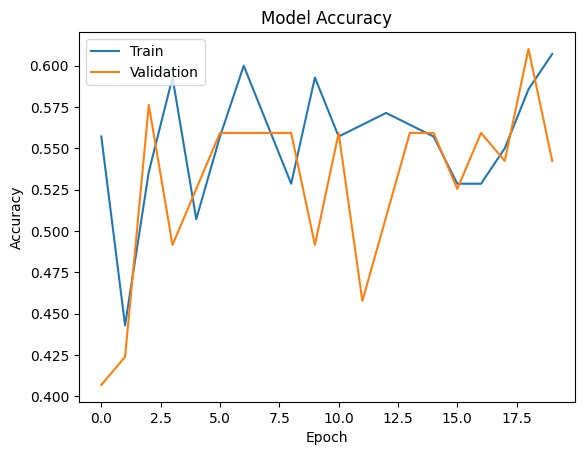

In [ ]:
# Plot training and validation accuracy
plt.plot(efficientnet_history.history['accuracy'])
plt.plot(efficientnet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

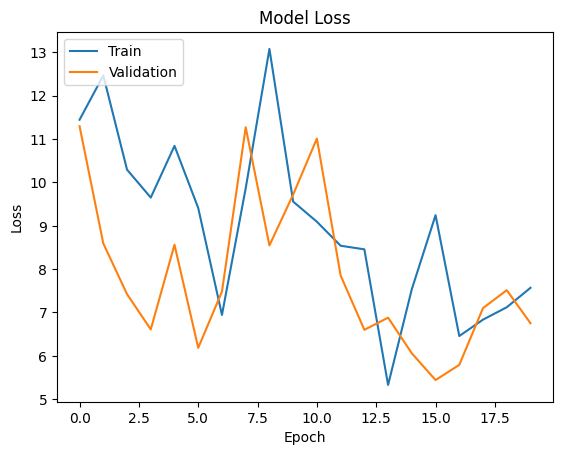

In [ ]:
# Plot training and validation loss
plt.plot(efficientnet_history.history['loss'])
plt.plot(efficientnet_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()